## importing the needed packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder, LabelEncoder, MinMaxScaler)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

### Uploading the data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

### Reading the data

In [ ]:
train1 = pd.read_csv('Train_Batch_1.csv')
train2 = pd.read_csv('Train_Batch_2.csv')
train3= pd.read_csv('Train_Batch_3.csv')
testing =  pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Data Exploration

In [ ]:
train1.head(5)

,Unnamed: 0,Person Description,Place Code,Customer Order,Additional Features in market,Promotion Name,Store Kind,Store Sales,Store Cost,Product Weights Data in (KG),Is Recyclable?,Min. Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost
0,mc_ID_0,"Single Female with four children, education: b...",H11go_ZA,"Cleaning Supplies from Household department, O...","['Video Store', 'Florist', 'Ready Food', 'Coff...",Dimes Off,Deluxe,8.76 Millions,4.2924 Millions,"{'Gross Weight': 28.1997, 'Net Weight': 26.600...",recyclable,10K+,2842.23,2037.64,481.98,323,602.7575
1,mc_ID_1,"Single Female with three children, education: ...",S04ne_WA,"Snack Foods from Snack Foods department, Order...",NaN,Budget Bargains,Supermarket,6.36 Millions,1.9716 Millions,"{'Gross Weight': 16.571, 'Net Weight': 14.972,...",non recyclable,50K+,2814.95,2049.72,457.36,NaN,708.6650
2,mc_ID_2,"Married Male with two children, education: hig...",L05es_CA,"Magazines from Periodicals department, Ordered...",['Florist'],Shelf Emptiers,Supermarket,10.86 Millions,4.4526 Millions,"{'Gross Weight': 28.6358, 'Net Weight': 27.182...",recyclable,30K+,2192.32,1322.21,523.32,348.85,564.2647
3,mc_ID_3,"Single Female with three children, education: ...",S03le_WA,"Dairy from Dairy department, Ordered Brand : C...",['Coffee Bar'],Savings Galore,NaN,1.98 Millions,0.6732 Millions,"{'Gross Weight': 14.2161, 'Net Weight': 11.294...",recyclable,30K+,1974.73,NaN,440.92,293.95,724.5119
4,mc_ID_4,"Married Female with five children, education: ...",M10da_YU,"Vegetables from Produce department, Ordered Br...","['Bar For Salad', 'Ready Food', 'Coffee Bar', ...",Sale Winners,Deluxe,11.56 Millions,4.9708 Millions,"{'Gross Weight': 12.6172, 'Net Weight': 9.71, ...",non recyclable,50K+,2862.3,1872.19,593.93,395.95,519.7574


Notes:
* the first unnamed column represents the id, we need to extract the integer part.

* we can extract some feature from the text data in the <B>person Description </B> column like the marital status and number of childern, same as the <B>customer order</B> column.

* we need to handel the the list values in the <B> Additional Features in market</B>.

* we need to strip the unit of measurement in the <B>Store Sales	 </B>, <B> Store Cost	</B>, <B> Min. Yearly Income	</B> columns.

* the dictionary value in the <B> Product Weights Data in (KG)</B> has three items which can be turned into three features: <B>Gross Weight</B>, <B>Net Weight</B>, <B>package weight</B>

* Gross Weight = Net Weight + package weight

In [ ]:
train2.head()

,Unnamed: 0,Person Description,Place Code,Customer Order,Additional Features in market,Promotion Name,Store Kind,Store Sales,Store Cost,Gross Weight,Net Weight,Is Recyclable?,Min. Person Yearly Income,Store Area,Grocery Area,Frozen Area,Meat Area,Cost
0,mc_ID_0,"Single Male with two children, education: high...",S01em_OR,"Baking Goods from Baking Goods department, Ord...","['Video Store', 'Florist', 'Ready Food', 'Bar ...",Tip Top Savings,Deluxe,3.28 M,0.984 M,21.9493,19.0421,yes,30K+,2577.50,1734.50,503.07,335.38,287.1270
1,mc_ID_1,"Married Male with four children, education: hi...",T02ma_WA,"Canned Sardines from Canned Foods department, ...","['Florist', 'Bar For Salad', 'Ready Food', 'Co...",Discount Frenzy,Deluxe,9.35 M,4.2075 M,19.1874,16.1349,yes,30K+,3145.51,2057.74,654.13,NaN,779.6884
2,mc_ID_2,"Married Female with three children, education:...",S04ne_WA,"Frozen Desserts from Frozen Foods department, ...",[],Tip Top Savings,Supermarket,8.4 M,3.192 M,16.7163,12.3555,no,30K+,2811.99,2049.72,457.36,304.91,557.8318
3,mc_ID_3,"Single Male with four children, education: par...",V13er_BC,"Frozen Desserts from Frozen Foods department, ...","['Coffee Bar', 'Ready Food', 'Bar For Salad', ...",Price Cutters,NaN,4.6 M,1.518 M,24.1296,NaN,yes,10K+,2147.17,NaN,373.1,248.79,642.0871
4,mc_ID_4,"Married Female with four children, education: ...",B14on_WA,"Meat from Deli department, Ordered Brand : Moms","['Ready Food', 'Bar For Salad']",Money Savers,Supermarket,6.81 M,3.2007 M,17.8792,16.4256,no,50K+,3685.30,2265.90,853.22,568.75,432.0503


notes:
* the only difference between the two datasets is that the second one has the <B>Gross Weight</B>, <B>Net Weight</B>	in two seperated columns. Meanwhile it does't have the value of the <B>Package Weight</B>, which can be easily fixed.

In [ ]:
train3.head()

,Unnamed: 0,Person%20Description,Place%20Code,Customer%20Order,Additional%20Features%20in%20market,Promotion%20Name,Store%20Kind,Store%20Sales,Store%20Cost,Gross%20Weight,Net%20Weight,Weights%20Data,Is%20Recyclable?,Yearly%20Income,Store%20Area,Grocery%20Area,Frozen%20Area,Meat%20Area,Cost
0,mc_ID_0,"Single Female with two children, education: pa...",T02ma_WA,"Meat from Deli department, Ordered Brand : Red...","['Coffee Bar', 'Florist', 'Ready Food', 'Bar F...",Sale : Double Down,Deluxe,7.12 Millions,2.5632 Millions,23.2575,20.3503,"{'Gross Weight': 23.2575, 'Net Weight': 20.350...",yes,90K+,3145.51,2056.79,654.13,436.09,500.7202
1,mc_ID_1,"Single Female with five children, education: p...",M10da_YU,"Specialty from Produce department, Ordered Bra...","['Coffee Bar', 'Florist', 'Bar For Salad', 'Vi...",GLD,Deluxe,14.72 Millions,7.0656 Millions,16.7163,12.3555,"{'Gross Weight': 16.7163, 'Net Weight': 12.355...",yes,30K+,2856.68,1871.16,595.93,395.51,484.1411
2,mc_ID_2,"Married Male with three children, education: h...",T02ma_WA,"Paper Products from Household department, Orde...","['Coffee Bar', 'Bar For Salad', 'Ready Food', ...",Promo Big,Deluxe,4.98 Millions,2.4402 Millions,10.5531,7.6459,"{'Gross Weight': 10.5531, 'Net Weight': 7.6459...",no,30K+,3140.99,2055.29,654.13,436.09,267.3576
3,mc_ID_3,"Married Female with five children, education: ...",H11go_ZA,"Snack Foods from Snack Foods department, Order...","['Video Store', 'Coffee Bar', 'Ready Food', 'F...",Price Destroyers,NaN,5.24 Millions,2.0436 Millions,23.6936,NaN,"{'Gross Weight': 23.6936, 'Net Weight': 20.641...",no,10K+,2841.35,2038.11,481.98,322.22,777.2826
4,mc_ID_4,"Married Female with No children, education: pa...",O09ba_VE,"Canned Soup from Canned Foods department, Orde...","['Ready Food', 'Bar For Salad']",Save Price,Supermarket,8.84 Millions,3.4476 Millions,13.6056,10.6839,"{'Gross Weight': 13.6056, 'Net Weight': 10.683...",no,110K+,3236.33,2448.37,472.27,313.87,406.4756


notes:
* we need to replace the %20 in the columns names with spaces
* we also need to extract the <B> package Weight</B> from the dictionary int <B>Weights%20Data</B> and remove that column.

###### Before completing the exploration part we need to merge the three datasets into one training set.

* we can do this by making them all have the same features with the same names.


### let's start with first one

In [ ]:
# extracting weights
train1['Gross Weight'] = train1['Product Weights Data in (KG)'].str.split(':').str.get(1).str.strip(", 'Net Weight'")
train1['Net Weight'] = train1['Product Weights Data in (KG)'].str.split(':').str.get(2).str.strip(", 'Package Weight'")
train1['Package Weight'] = train1['Product Weights Data in (KG)'].str.split(':').str.get(3).str.strip("}")

# fixing the data type
train1[['Gross Weight', 'Net Weight', 'Package Weight']]= train1[['Gross Weight', 'Net Weight', 'Package Weight']].astype('float')

# renaming the 'Min. Yearly Income' column
train1.rename(columns={'Min. Yearly Income': 'Yearly Income'}, inplace = True)

# Reordering the columns
train1 = train1[['Unnamed: 0', 'Person Description', 'Place Code', 'Customer Order', 'Additional Features in market', 'Promotion Name', 'Store Kind', 'Store Sales',
                'Store Cost', 'Gross Weight', 'Net Weight', 'Package Weight', 'Is Recyclable?', 'Yearly Income', 'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost']]


### now it's time to fix the second dataset


In [ ]:
# Creating the package Weight column
train2['Package Weight'] = train2['Gross Weight'] - train2['Net Weight']

# renaming the 'Min. Yearly Income' column
train2.rename(columns={'Min. Person Yearly Income': 'Yearly Income'}, inplace = True)

# Reordering the columns
train2 = train2[['Unnamed: 0', 'Person Description', 'Place Code', 'Customer Order', 'Additional Features in market', 'Promotion Name', 'Store Kind', 'Store Sales',
                'Store Cost', 'Gross Weight', 'Net Weight', 'Package Weight', 'Is Recyclable?', 'Yearly Income', 'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost']]


### finally we are going to fix the last one


In [ ]:
# first we need to replace the '%20' in the columns names with ' '
train3.columns = train3.columns.str.replace('%20', ' ')

# extracting weights
train3['Gross Weight'] = train3['Weights Data'].str.split(':').str.get(1).str.strip(", 'Net Weight'")
train3['Net Weight'] = train3['Weights Data'].str.split(':').str.get(2).str.strip(", 'Package Weight'")
train3['Package Weight'] = train3['Weights Data'].str.split(':').str.get(3).str.strip("}")

# fixing the data type
train3[['Gross Weight', 'Net Weight', 'Package Weight']]= train3[['Gross Weight', 'Net Weight', 'Package Weight']].astype('float')

# Reordering the columns
train3 = train3[['Unnamed: 0', 'Person Description', 'Place Code', 'Customer Order', 'Additional Features in market', 'Promotion Name', 'Store Kind', 'Store Sales',
                'Store Cost', 'Gross Weight', 'Net Weight', 'Package Weight', 'Is Recyclable?', 'Yearly Income', 'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Cost']]


### Now we are able to merge the three datasets to complete the Exploration phase

In [ ]:
training= result = pd.concat([train1, train2, train3], ignore_index=True)

### Completing The Exploration

In [ ]:
training.shape

(38862, 19)

In [ ]:
training.isna().sum()

Unnamed: 0                          0
Person Description                  0
Place Code                          0
Customer Order                      2
Additional Features in market    4300
Promotion Name                   5828
Store Kind                       5809
Store Sales                        15
Store Cost                          7
Gross Weight                     1942
Net Weight                       1938
Package Weight                   3578
Is Recyclable?                      2
Yearly Income                       8
Store Area                       3565
Grocery Area                     3606
Frozen Area                      3552
Meat Area                        3549
Cost                               31
dtype: int64

#### some columns has many missing values needs to be imputed

In [ ]:
training.duplicated().sum()

8

#### number of duplicated values is really small we may remove it

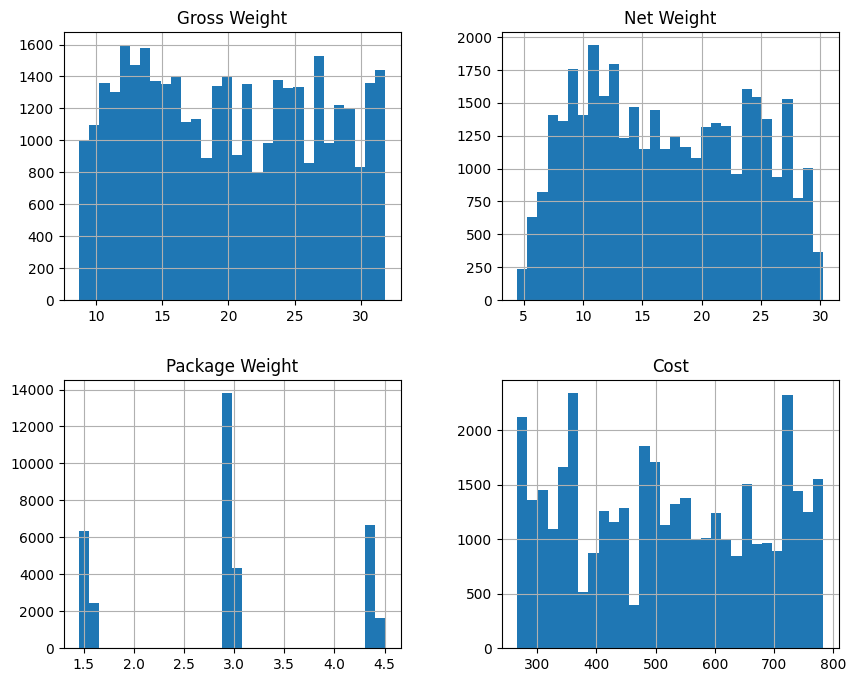

In [ ]:
training.hist(bins=30, figsize= (10, 8))
plt.show()

In [ ]:
training.describe()

,Gross Weight,Net Weight,Package Weight,Cost
count,36920.000000,36924.000000,35284.000000,38831.000000
mean,20.054378,17.141925,2.925647,519.224643
std,6.716412,6.813656,1.010982,156.875169
min,8.721600,4.433500,1.453500,265.631700
25%,14.056200,11.207200,2.907100,364.269500
50%,19.768900,16.861700,2.907200,515.259600
75%,25.728600,23.257500,3.052500,662.222600
max,31.833700,30.234700,4.506200,783.192500


### Cleaning the <b> Person Description	</b> column

In [ ]:
def clean_person_description(X):

  df= X.copy()

  # extracting the marital status
  df['Marital_Status']= df['Person Description'].str.split().str.get(0)

  # extracting the gender
  df['Gender']= df['Person Description'].str.split().str.get(1)

  # extracting number of childern
  number_mapping = { 'No':0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5}
  df['num_children'] = df['Person Description'].str.split().str.get(3).replace(number_mapping)

  # extracting the education from text
  df['Education']= df['Person Description'].str.split(': ').str.get(1).str.split(' working').str.get(0)

  # extracting the work from the text by spliting the text
  df['Work']= df['Person Description'].str.split('as').str.get(1).str.strip()

  # changing datatype to category
  columns= ['Marital_Status', 'Gender', 'Education', 'Work']
  df[columns] = df[columns].astype('category')

  # dropping the original column
  df = df.drop('Person Description', axis= 1)

  return df

In [ ]:
cleaning_person_description = FunctionTransformer(clean_person_description)

cleaned_person = cleaning_person_description.fit_transform(training)

cleaned_person[['Marital_Status', 'Gender', 'Education', 'Work']].head()

,Marital_Status,Gender,Education,Work
0,Single,Female,bachelors degree,professional
1,Single,Female,bachelors degree,management
2,Married,Male,high school degree,skilled manual
3,Single,Female,partial college,professional
4,Married,Female,bachelors degree,professional


In [ ]:
cleaned_person['Work'].unique()

['professional', 'management', 'skilled manual', 'manual', 'clerical']
Categories (5, object): ['clerical', 'management', 'manual', 'professional', 'skilled manual']

### Cleaning the <b> Customer Order	</b> column

In [ ]:
def clean_customer_order(X):

  df= X.copy()

  # extracting the product brand
  df['Brand'] = df['Customer Order'].str.split(':').str.get(1).str.strip()

  # extracting the product type
  df['Product_Type'] = df['Customer Order'].str.split('from').str.get(0).str.strip()

  # extracting the product department
  df['Department'] = df['Customer Order'].str.split('from').str.get(1).str.split('department').str.get(0).str.strip()

  # removing the original column
  df = df.drop('Customer Order', axis=1)

  return df

In [ ]:
cleaning_customer_order = FunctionTransformer(clean_customer_order)

cleaned_customer = cleaning_customer_order.fit_transform(cleaned_person)

cleaned_customer[['Brand', 'Product_Type', 'Department']].head()

,Brand,Product_Type,Department
0,Red Wing,Cleaning Supplies,Household
1,Nationeel,Snack Foods,Snack Foods
2,Excel,Magazines,Periodicals
3,Carlson,Dairy,Dairy
4,Hermanos,Vegetables,Produce


### Cleaining the <b> store cost </b> , <b>store sales</b> ans <b> yearly income </b> columns


In [ ]:
def sales_cost_income(X):

  df = X.copy()

  columns= ['Store Cost', 'Yearly Income', 'Store Sales']


  # extracting the numeric part
  for col in columns:
    df[col] = df[col].str.strip('MillionsMK+. ')

  # changing the datatype to integer
  df[columns]= df[columns].astype('float')

  return df


In [ ]:
cleaning_sales_cost_income = FunctionTransformer(sales_cost_income)

cleaned_sales_cost_income = cleaning_sales_cost_income.fit_transform(training)

cleaned_sales_cost_income[['Store Cost', 'Yearly Income', 'Store Sales']].head()

,Store Cost,Yearly Income,Store Sales
0,4.2924,10.0,8.76
1,1.9716,50.0,6.36
2,4.4526,30.0,10.86
3,0.6732,30.0,1.98
4,4.9708,50.0,11.56


### Cleaining the <b> Additional Features in market </b> column

In [ ]:
def clean_features(X):

  df=X.copy()

  # imputing missing values
  df['Additional Features in market'] = df['Additional Features in market'].fillna(  df['Additional Features in market'].mode()[0])

  # List of categories
  categories = ['Video Store', 'Florist', 'Ready Food', 'Coffee Bar', 'Bar For Salad']

  for cat in categories:
    df[cat] = df['Additional Features in market'].apply(lambda x: 1 if cat in x else 0)

  # Drop the original column
  df = df.drop('Additional Features in market', axis=1)

  return df

In [ ]:
cleaning_features = FunctionTransformer(clean_features)

cleaned_features = cleaning_features.fit_transform(training)

cleaned_features[['Video Store', 'Florist', 'Ready Food', 'Coffee Bar', 'Bar For Salad']].head()

,Video Store,Florist,Ready Food,Coffee Bar,Bar For Salad
0,1,1,1,1,1
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,1,1,1,1,1


### Cleaning the <b>Is Recyclable?</b>column

In [ ]:
def cleaning_recyclable(X):
  df = X.copy()

  df['Is Recyclable?'] =   df['Is Recyclable?'].replace({'non recyclable': 'no', 'recyclable': 'yes'})
  return df

### Handeling the Area Columns

In [ ]:
def Area_columns(X):

  df= X.copy()

  columns = ['Store Area', 'Frozen Area', 'Grocery Area', 'Meat Area']

  for column in columns:
    training[column] = pd.to_numeric(training[column], errors='coerce')

  df['Store Area'] =   df['Store Area'].fillna(df['Frozen Area'] + df['Meat Area'] + df['Grocery Area'])
  df['Frozen Area'] =  df['Frozen Area'].fillna(df['Store Area'] - df['Meat Area'] - df['Grocery Area'])
  df['Meat Area'] =  df['Meat Area'].fillna(df['Store Area'] - df['Frozen Area'] - df['Grocery Area'])
  df['Grocery Area'] =  df['Grocery Area'].fillna(df['Store Area'] - df['Meat Area'] - df['Frozen Area'])

  if df[columns].isna().sum().sum() != 0:
    imputer  = SimpleImputer(strategy='median')
    df[columns] = imputer.fit_transform(df[columns])

    return df

### Dropping the unuseful columns

In [ ]:
def drop_columns(X):

  df = X.copy()

  # unuseful columns
  columns = ['Unnamed: 0', 'Place Code',  'Promotion Name',  'Store Area', 'Grocery Area', 'Frozen Area', 'Meat Area', 'Brand', 'Product_Type', 'Department']

  # removing columns
  df = df.drop(columns, axis=1)

  return df

### Imputing missing values

In [ ]:
def Imputation(X):
    df = X.copy()

    # Dropping rows with missing values in selected columns
    columns_to_drop_na = ['Customer Order', 'Store Sales', 'Store Cost', 'Is Recyclable?', 'Yearly Income']
    df = df.dropna(subset=columns_to_drop_na)

    # Impute numerical columns with mean
    num_columns = ['Gross Weight', 'Net Weight', 'Package Weight']
    num_imputer = SimpleImputer(strategy='mean')
    df[num_columns] = num_imputer.fit_transform(df[num_columns])

    # Impute categorical columns with mode
    cat_columns = ['Additional Features in market', 'Promotion Name', 'Store Kind']
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_columns] = cat_imputer.fit_transform(df[cat_columns])

    # dropping missing values of the target column
    if 'Cost' in df.columns:
      df = df.dropna(subset='Cost')

    return df

### Categorical columns encoding

In [ ]:
def encoding_columns(X):
    df = X.copy()

    # One-Hot Encoding
    columns_one = ['Marital_Status', 'Gender', 'Store Kind', 'Is Recyclable?']

    one_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    one_encoded = pd.DataFrame(one_encoder.fit_transform(df[columns_one]), index= df.index)

    df = df.drop(columns=columns_one)

    df = pd.concat([df, one_encoded], axis=1)


    # Ordinal Encoding
    columns_ordinal = ['Education', 'Work']
    ordinal_encoder = OrdinalEncoder()
    df[columns_ordinal] = ordinal_encoder.fit_transform(df[columns_ordinal])

    return df

### Scaling numeric columns

In [ ]:
def scaling_nums(X):
  df = X.copy()

  columns= ['num_children', 'Store Cost', 'Yearly Income', 'Store Sales', 'Gross Weight', 'Net Weight', 'Package Weight', 'Store Area', 'Frozen Area', 'Grocery Area', 'Meat Area']
  scaler = StandardScaler()
  df[columns] = scaler.fit_transform(df[columns])

  return df

In [ ]:
def transformation(X):

  df = X.copy()

  for col in ['Store Sales', 'Store Cost']:
    df[col]= np.log(df[col])

  return df

In [ ]:
def full_cleaning(X):

  df = X.copy()

  df = Imputation(df)

  df = clean_person_description(df)

  df = clean_customer_order(df)

  df = sales_cost_income(df)

  df = clean_features(df)

  df = cleaning_recyclable(df)

  df = Area_columns(df)

  df = scaling_nums(df)

#  df = transformation(df)

  df = encoding_columns(df)

  df = drop_columns(df)

  return df

In [ ]:
Full_Cleaning = FunctionTransformer(full_cleaning)

train = Full_Cleaning.fit_transform(training)

In [ ]:
train.head()

,Store Sales,Store Cost,Gross Weight,Net Weight,Package Weight,Yearly Income,Cost,num_children,Education,Work,...,1,2,3,4,5,6,7,8,9,10
0,0.643579,1.158289,1.244040,1.423909,-1.377683,-1.059942,602.7575,0.988595,0.0,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.049342,-0.442102,-0.532263,-0.326805,-1.377683,0.044018,708.6650,0.316929,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.249885,1.268760,1.310655,1.511439,-1.528642,-0.507962,564.2647,-0.354738,2.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-1.313924,-1.337460,-0.891977,-0.880466,-0.004413,-0.507962,724.5119,0.316929,3.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.451987,1.626104,-1.136212,-1.118998,-0.019467,0.044018,519.7574,1.660261,0.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
x_train = train.drop('Cost', axis=1)
y_train = train['Cost']

x_train.columns= x_train.columns.astype(str)

In [ ]:
test = testing.copy()
test = Full_Cleaning.transform(test)


In [ ]:
test.head()

,Store Sales,Store Cost,Gross Weight,Net Weight,Package Weight,Yearly Income,num_children,Education,Work,Video Store,...,1,2,3,4,5,6,7,8,9,10
0,1.506336,1.425571,1.795516,1.750523,0.129439,0.052972,0.973526,4.0,4.0,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-1.269672,-1.345187,1.506794,1.487197,-0.013841,0.611598,0.303568,1.0,3.0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.365097,-1.239491,1.395749,1.377476,-0.013841,2.287477,0.303568,4.0,1.0,1,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.656183,1.223656,1.218073,1.179986,0.129439,-1.064281,0.303568,4.0,2.0,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.645070,-0.440282,0.529600,0.521664,-0.013841,-0.505655,-0.366391,2.0,2.0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
test = test.columns.astype(str)

In [ ]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Fit Random Forest
rf_model.fit(x_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort and select features
sorted_indices = np.argsort(feature_importances)[::-1]
num_selected_features = 25  # Change this to the desired number of features
selected_feature_indices = sorted_indices[:num_selected_features]
selected_features = x_train.columns[selected_feature_indices]

print("Selected features:", selected_features)

Selected features: Index(['Store Cost', 'Store Sales', 'Gross Weight', 'Net Weight',
       'Video Store', 'num_children', 'Yearly Income', 'Work', '4',
       'Education', 'Package Weight', '6', 'Florist', '5', '2', '3', '1', '0',
       '10', '8', '9', 'Coffee Bar', 'Bar For Salad', 'Ready Food', '7'],
      dtype='object')


In [ ]:
x_train.columns

Index(['Store Sales', 'Store Cost', 'Gross Weight', 'Net Weight',
       'Package Weight', 'Yearly Income', 'num_children', 'Education', 'Work',
       'Video Store', 'Florist', 'Ready Food', 'Coffee Bar', 'Bar For Salad',
       '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
      dtype='object')

In [ ]:
reg = Ridge(alpha=1.0)

reg.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(reg, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)

RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 154.95957921530152


In [ ]:
las = Lasso(alpha=0.1)

las.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(las, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)

RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 154.9484479494218


In [ ]:
dt = DecisionTreeRegressor(max_depth=5)

dt.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(dt, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)


RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 154.75550020320838


In [ ]:
rf = RandomForestRegressor()

rf.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)

RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 155.49366082076892


In [ ]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

gb.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(gb, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)

RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 154.64187135922433


In [ ]:
XGB = XGBRegressor(n_estimators=1000, colsample_bytree= 0.4, gamma= 0.0 , max_depth=8,
                   eta=0.1, subsample=0.7, learning_rate= 0.15, min_child_weight= 1)

XGB.fit(x_train, y_train)

train_pred = reg.predict(x_train)

print("RMSE on training set:" , np.sqrt(mean_squared_error(y_train, train_pred)))

cv_scores = cross_val_score(XGB , x_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-1 * cv_scores.mean())
print("RMSE on cross-validation cv:", cv_rmse)

RMSE on training set: 154.87831067291248
RMSE on cross-validation cv: 168.14826134872666
